In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# def rand_submatrix_row(A, d):
#     assert len(A[0]) == len(A)
#     indices = np.random.choice(np.arange(len(A)), d)
# #     print(indices)
#     return A[indices]

# def rand_submatrix_col(A, d):
#     assert len(A[0]) == len(A)
#     indices = np.random.choice(np.arange(len(A)), d)
# #     print(indices)
#     return A[:, indices]

def sample_submatrix_row(A, indices):
    return A[:, indices]

def sample_submatrix_col(B, indices):
    return B[indices]

def gen_opt_weights(A, B):
    assert A.shape == B.shape
    w = []
    for i in range(len(A)):
        Af = np.linalg.norm(A[i])
        Bf = np.linalg.norm(B[:, i])
        w.append(Af*Bf)
    w = np.array(w)
    return w/(np.sum(w))

def sketched_mat_mul_w(A, B, d, w):
    indices = np.random.choice(np.arange(len(A)), d, p = w)
    return sample_submatrix_row(A, indices)@np.diag(np.reciprocal(d*w[indices]))@sample_submatrix_col(B, indices)    

def sketched_mat_mul(A, B, d):
    w = gen_opt_weights(A, B)
    
    indices = np.random.choice(np.arange(len(A)), d, p = w)
    return sample_submatrix_row(A, indices)@np.diag(np.reciprocal(d*w[indices]))@sample_submatrix_col(B, indices)

In [93]:
import time
import math

def do_sims(Ks, gen_method):
    theory_errs = []
    opt_errs = []
    errs = []
    C_times = []
    D_times = []
    A_frob_norms= []
    B_frob_norms = []
    prod_frob_norms = []

    theory_errs = []

    for k in Ks:
#         print(k)

        A = gen_method(k)
        B = gen_method(k)

        d = int(math.log(k))
        opt_indices = np.random.choice(np.arange(len(A)), d, p = gen_opt_weights(A, B))
        indices = np.random.choice(np.arange(len(A)), d)

        A_ = sample_submatrix_row(A, indices)
        B_ = sample_submatrix_col(B, indices)
        start = time.process_time()
        C1 = (A_@B_)*(k/d)



        C2 = sketched_mat_mul(A, B, d)
        C_time = time.process_time() - start    
        start = time.process_time()
        D = A@B
        D_time = time.process_time() - start
        C_times.append(C_time)
        D_times.append(D_time)

        A_frob_norm = np.linalg.norm(A)
        B_frob_norm = np.linalg.norm(B)
        D_frob_norm = np.linalg.norm(D)

        theory_errs.append(math.sqrt(np.sum([np.linalg.norm(A[:, i])*np.linalg.norm(B[i]) for i in range(0, k)])**2/d - D_frob_norm**2/d)) #Check rows/columns

        prod_frob_norms.append(D_frob_norm)
        A_frob_norms.append(A_frob_norm)
        B_frob_norms.append(B_frob_norm)
        errs.append(np.linalg.norm(C1 - D))
        opt_errs.append(np.linalg.norm(C2 - D))
        
    return {"opt_errs": opt_errs, "errs": errs, "product norms": prod_frob_norms, "A norms": A_frob_norms, "B norms": B_frob_norms, "theory": theory_errs, "C times": C_times, "D times": D_times}

In [99]:
def gaussian_matrix(k):
    return np.random.normal(0, 1, k**2).reshape(k, k)

def arange_matrix(k):
    return np.arange(0, k**2).reshape(k, k)

from scipy.stats import ortho_group
def scale_and_rotate(k):
    return ortho_group.rvs(k)@np.diag(np.ones(k)/math.sqrt(k))

import random
from itertools import combinations

def random_laplacian(k):
    A = np.zeros((k, k))
    p = 1
    for i, j in combinations(list(range(k)), 2):
        if random.random() < p:
            A[i, j] = -1
            A[j, i] = -1
    np.fill_diagonal(A, np.sum(np.abs(A), axis = 1))
    return A

In [95]:
Ks = np.array([k for k in range(50, 2000, 100)])
gaussian_sims = do_sims(Ks, gaussian_matrix)
arange_sims = do_sims(Ks, arange_matrix)


In [96]:
scaled_sims = do_sims(Ks, scale_and_rotate)

In [100]:
laplacian_sims = do_sims(Ks, random_laplacian)

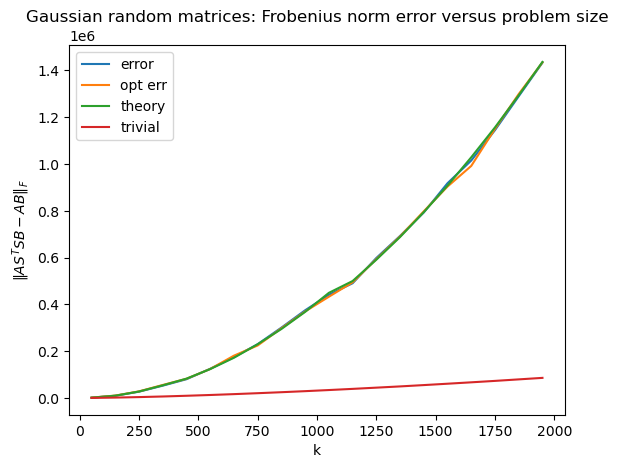

In [51]:
plt.title("Gaussian random matrices: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.plot(Ks, gaussian_sims["errs"], label = "error")
plt.plot(Ks, gaussian_sims["opt_errs"], label = "opt err")
plt.plot(Ks, gaussian_sims["theory"], label = "theory")
plt.plot(Ks, gaussian_sims["product norms"], label = "trivial")


plt.legend()

# Note, numpy optimizations for mat mul is changing the amount of time this takes. Should do these sims with naive mat mul algorithm

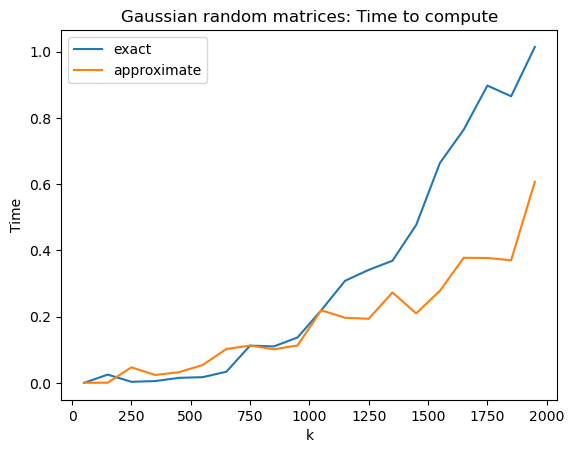

In [52]:
plt.title("Gaussian random matrices: Time to compute")
plt.ylabel("Time")
plt.xlabel("k")
plt.plot(Ks, gaussian_sims["D times"], label = "exact")
plt.plot(Ks, gaussian_sims["C times"], label = "approximate")

# plt.plot(Ks, [k**2*math.log(k) for k in Ks])
plt.legend()

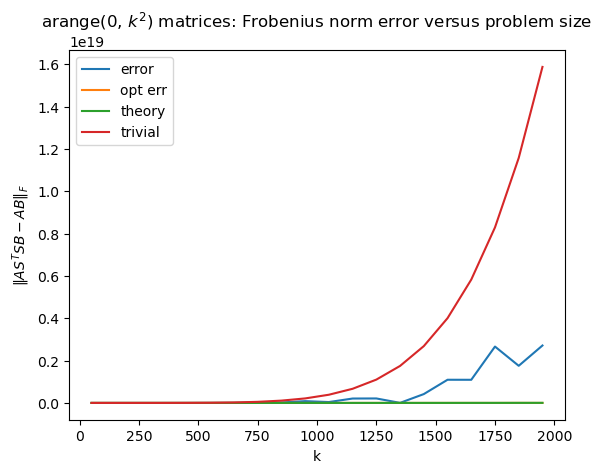

In [53]:
plt.title("arange(0, $k^2$) matrices: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.plot(Ks, arange_sims["errs"], label = "error")
plt.plot(Ks, arange_sims["opt_errs"], label = "opt err")
plt.plot(Ks, arange_sims["theory"], label = "theory")

plt.plot(Ks, arange_sims["product norms"], label = "trivial")


plt.legend()

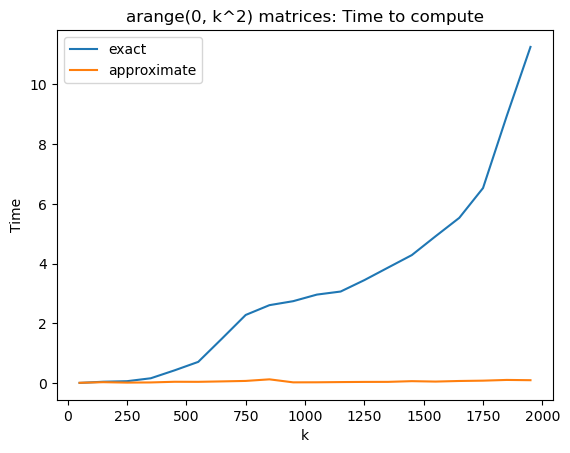

In [54]:
plt.title("arange(0, k^2) matrices: Time to compute")
plt.ylabel("Time")
plt.xlabel("k")
plt.plot(Ks, arange_sims["D times"], label = "exact")
plt.plot(Ks, arange_sims["C times"], label = "approximate")


# plt.plot(Ks, [k**2*math.log(k) for k in Ks])
plt.legend()

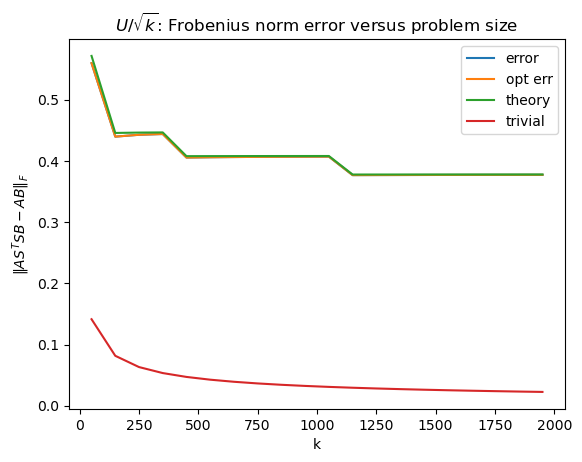

In [55]:
plt.title("$U/\sqrt{k}$: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.plot(Ks, scaled_sims["errs"], label = "error")
plt.plot(Ks, scaled_sims["opt_errs"], label = "opt err")
plt.plot(Ks, scaled_sims["theory"], label = "theory")
plt.plot(Ks, scaled_sims["product norms"], label = "trivial")
# plt.plot(Ks, scaled_sims["product norms"])
plt.legend()

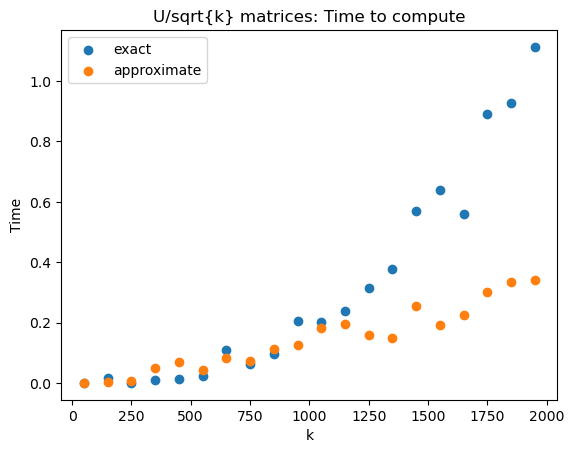

In [57]:
plt.title("U/sqrt{k} matrices: Time to compute")
plt.ylabel("Time")
plt.xlabel("k")
plt.scatter(Ks, scaled_sims["D times"], label = "exact")
plt.scatter(Ks, scaled_sims["C times"], label = "approximate")
# plt.plot(Ks, [k**2*math.log(k) for k in Ks])
plt.legend()

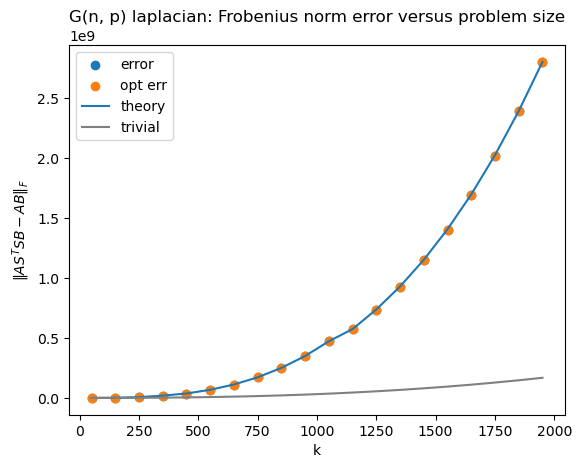

In [101]:
plt.title("G(n, p) laplacian: Frobenius norm error versus problem size")
plt.ylabel("$\|AS^TSB - AB\|_F$")
plt.xlabel("k")
plt.scatter(Ks, laplacian_sims["errs"], label = "error")
plt.scatter(Ks, laplacian_sims["opt_errs"], label = "opt err")
plt.plot(Ks, laplacian_sims["theory"], label = "theory")
plt.plot(Ks, laplacian_sims["product norms"], label = "trivial", color = "gray")
# plt.plot(Ks, scaled_sims["product norms"])
plt.legend()

In [71]:
print(A)

None
